In [60]:
from collections import defaultdict
import copy
import itertools as it
import json
import os
import sys
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import cv2
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import networkx as nx
import numpy as np
from scipy import stats
import torch
import vizdoom as vzd

from rlpyt.envs.vizdoom.vizdoom_env import VizDoomEnv
import rlpyt.models.resnet as resnet
from rlpyt.models.dqn.dsr.dsr_model import DsrModel
from rlpyt.models.dqn.dsr.tcf_model import FixedVizDoomModel
from rlpyt.utils.seed import make_seed, get_seed

vzd_dir = 'vizdoom_data'
import keras
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

from itertools import tee, islice
def nwise(iterable, n=2):                                                      
    iters = tee(iterable, n)                                                     
    for i, it in enumerate(iters):                                               
        next(islice(it, i, i), None)                                               
    return zip(*iters)

np.random.seed(333)
device = torch.device('cuda', index=0)

In [64]:
for _ in range(4):
    print(make_seed())

5011
9029
7880
5666


In [3]:
def plot_topdown(env, fig):
    env.reset()
    state = env.state

    for s in state.sectors:
        # Plot sector on map
        for l in s.lines:
            if l.is_blocking:
                fig.plot([l.x1, l.x2], [l.y1, l.y2], color='black', linewidth=2)

def get_s_features(state, feature_model, dsr_model, norm=True, numpy=True):
    features = feature_model(torch.Tensor(state).unsqueeze(0).to(device))
    s_features = dsr_model(features, mode='dsr')
    if norm:
        s_features = torch.mean(s_features, dim=1)
        s_features = s_features / torch.norm(s_features, p=2, dim=1, keepdim=True)
    if numpy:
        s_features = s_features.detach().cpu().numpy().squeeze()
    return s_features

## Visualization: local policy success rate over time

In [4]:
eval_dir = '../data/local/20201001/vizdoom/run_9'

In [5]:
config = json.load(open(os.path.join(eval_dir, 'params.json')))
config['env']['config'] = '../' + config['env']['config']
config['agent']['feature_model_kwargs']['fixed_weights_path'] = '../' + \
    config['agent']['feature_model_kwargs']['fixed_weights_path'] 

In [6]:
with open('../experiments/configs/2589-small-fixed-start-goal-pairs.json') as f:
    goal_pairs = json.load(f)

In [8]:
env = VizDoomEnv(**config['env'])

In [66]:
env.agent_pos

array([128.       , -64.       , 269.0002442])

In [70]:
env.step(2).env_info.position

(125.65666198730469, -202.88275146484375, 269.0002442032565)

In [9]:
feature_model = FixedVizDoomModel(**config['agent']['feature_model_kwargs'])
feature_model.to(device)
weights = torch.load(os.path.join(eval_dir, 'itr_{}.pkl'.format(itr)), map_location=device)
dsr_model = DsrModel(env.observation_space.shape,
                     env.action_space.n, **config['agent']['model_kwargs']).to(device)
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()
dsr_model.to(device)

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=14336, bias=True)
    )
  )
  (q_estimate): Linear(in_features=2048, out_features=1, bias=True)
)

In [36]:
itr = 200000 - 1

In [37]:
landmarks = np.load(os.path.join(eval_dir, 'landmarks_itr_{}.npz'.format(itr)))

In [38]:
positions = landmarks['positions']
N = len(positions)

dsr = landmarks['dsr']
norm_dsr = dsr / np.linalg.norm(dsr, ord=2, axis=1, keepdims=True)
dsr_sim = np.matmul(norm_dsr, norm_dsr.T)
dsr_sim[np.eye(N, dtype=bool)] = -1
features = landmarks['features']
norm_features = features / np.linalg.norm(features, ord=2, axis=1, keepdims=True)
feature_sim = np.matmul(norm_features, norm_features.T)

edge_random_steps = landmarks['edge_random_steps']
edge_random_transitions = landmarks['edge_random_transitions']
edge_subgoal_steps = landmarks['edge_subgoal_steps']
edge_subgoal_failures = landmarks['edge_subgoal_failures']
edge_subgoal_transitions = landmarks['edge_subgoal_transitions']

random_steps = edge_random_steps + np.tril(edge_random_steps, -1).T
random_transitions = edge_random_transitions + np.tril(edge_random_transitions, -1).T

subgoal_steps = edge_subgoal_steps + np.tril(edge_subgoal_steps, -1).T
subgoal_failures = edge_subgoal_failures + np.tril(edge_subgoal_failures, -1).T
subgoal_transitions = edge_subgoal_transitions + np.tril(edge_subgoal_transitions, -1).T

average_random_steps = random_steps / np.clip(random_transitions, 1, None)
average_subgoal_steps = subgoal_steps / np.clip(subgoal_transitions, 1, None)

transitions = random_transitions + subgoal_transitions

In [39]:
print('Number of landmarks:', N)
print('Number of non-zero random transitions:', np.argwhere(random_transitions > 0).shape[0])
percentile = 50
threshold = np.percentile(random_transitions[random_transitions > 0], percentile)
print('{} percentile of random transitions:'.format(percentile), 
      threshold)

temporally_nearby_threshold = max(N // 10, 10)
temporally_nearby_landmarks = np.tril(np.triu(np.ones((N), dtype=bool), 1), temporally_nearby_threshold)

subgoal_edges = np.argwhere(subgoal_transitions > 0)
print('Number of subgoal edges:', subgoal_edges.shape[0])
failure_edges = np.argwhere(subgoal_failures > 0)
print('Number of failure edges:', failure_edges.shape[0])

true_edges = random_transitions >= threshold
true_edges = temporally_nearby_landmarks & true_edges

k = 5
nearest_neighbors = np.argpartition(true_edges * random_transitions, -k)[:, -k:]
k_filter = np.zeros((N, N), dtype=bool)
idx = np.vstack([np.arange(N)] * k).T
k_filter[idx, nearest_neighbors] = True
true_edges = k_filter & true_edges

# true_edges = (subgoal_failures <= 1) & true_edges

edge_weights = true_edges * (np.exp(-1 * random_transitions))
edge_weights[(edge_weights > 0) & (subgoal_failures > 1)] = \
    edge_weights[(edge_weights > 0) & (subgoal_failures >1)] + 5000

print('Number of edges:', np.sum(edge_weights > 0))
edges = np.argwhere(edge_weights > 0)

Number of landmarks: 517
Number of non-zero random transitions: 14277
50 percentile of random transitions: 2.0
Number of subgoal edges: 2055
Number of failure edges: 522
Number of edges: 1440


In [40]:
def get_path(goal_pair):
    start_pos, goal_pos = goal_pair
    start_state, start_pos = env.get_obs_at(start_pos, idx=3)
    goal_state, goal_pos = env.get_obs_at(goal_pos, idx=-1)
    start_sf = get_s_features(start_state)
    goal_sf = get_s_features(goal_state)

    start_sim = np.matmul(norm_dsr, start_sf).max()
    start_landmark = np.matmul(norm_dsr, start_sf).argmax()

    goal_sim = np.matmul(norm_dsr, goal_sf.T).max()
    goal_landmark = np.matmul(norm_dsr, goal_sf.T).argmax()

    print('SF start:', start_landmark)
    print('SF goal:', goal_landmark)
    
    graph = nx.from_numpy_array(edge_weights)
    has_path = nx.has_path(graph, start_landmark, goal_landmark)
    if has_path:
        path = nx.shortest_path(graph, start_landmark, goal_landmark, weight='weight')
        print('Found path:', path)
    else:
        path = None
        print('No path from {} to {}'.format(start_landmark, goal_landmark))
    
    return start_pos, goal_pos, path

In [41]:
visitations = np.sum(random_transitions, axis=0)
visitations_percentile = stats.rankdata(visitations, 'average') / len(visitations)

In [42]:
env.start_info[1]

array([128.       , -64.       , 269.0002442])

<Figure size 432x288 with 0 Axes>

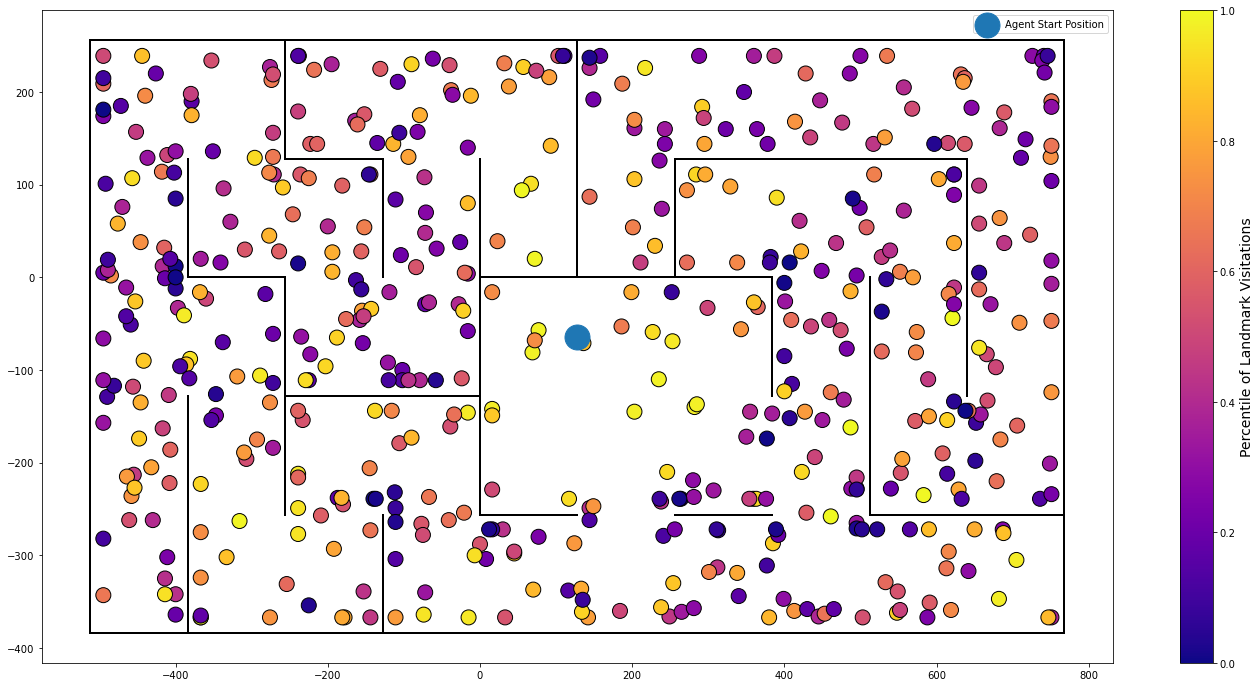

In [43]:
plt.set_cmap('plasma')
fig = plt.figure(figsize=(24, 12))

env.plot_topdown(False)

plt.scatter(positions[:, 0], positions[:, 1], c=visitations_percentile, s=225, linewidth=1, edgecolor='black')
plt.scatter(*env.start_info[1][:2], s=625, color='tab:blue', label='Agent Start Position')
plt.legend()
cbar = plt.colorbar()
cbar.set_label('Percentile of Landmark Visitations', fontsize=14)

<Figure size 432x288 with 0 Axes>

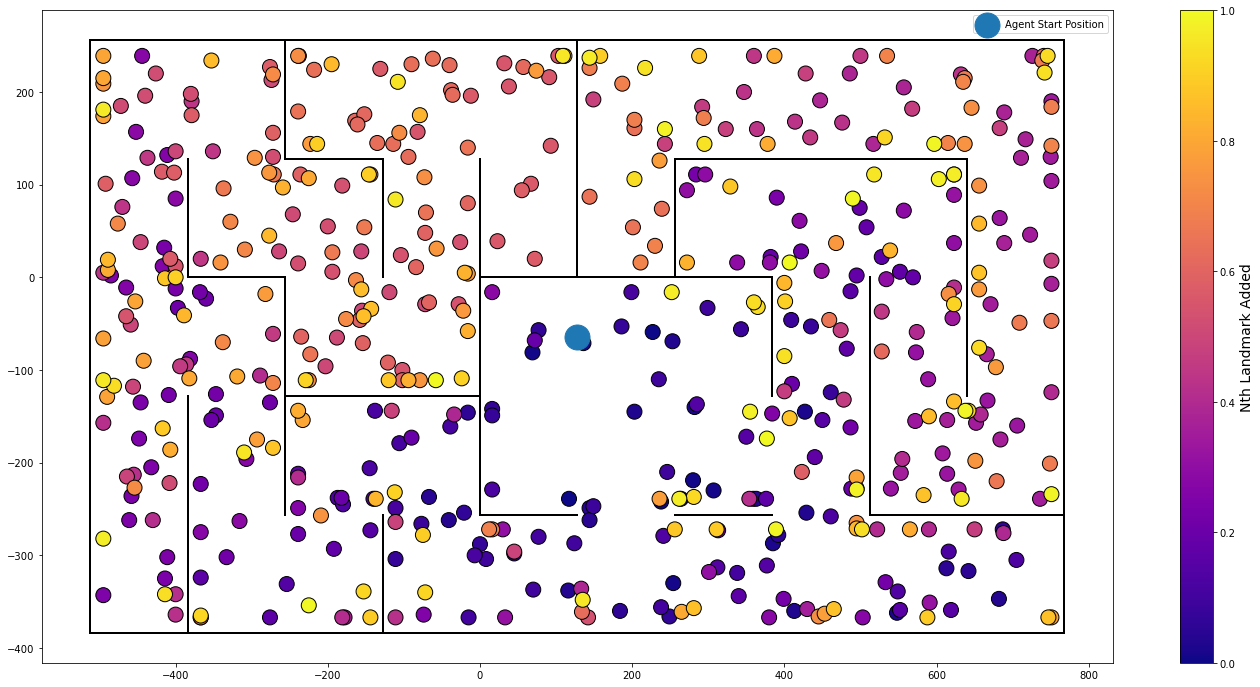

In [46]:
plt.set_cmap('plasma')
fig = plt.figure(figsize=(24, 12))

env.plot_topdown(False)

plt.scatter(positions[:, 0], positions[:, 1], c=np.arange(N), s=225, linewidth=1, edgecolor='black')
plt.scatter(*env.start_info[1][:2], s=625, color='tab:blue', label='Agent Start Position')
plt.legend()
cbar = plt.colorbar()
cbar.set_label('Nth Landmark Added', fontsize=14)

In [47]:
goal_pair = [[128, -64, 0], [535, 85, 270]]  # goal_pairs['hard'][4]
good_start, good_goal, good_path = get_path(goal_pair)

TypeError: get_s_features() missing 2 required positional arguments: 'feature_model' and 'dsr_model'

In [ ]:
exploration_path = good_path[:4]
exploration_landmarks = exploration_path + random_transitions[exploration_path].argmax(axis=1).tolist()[:-1]
cross_exploration_landmarks = np.array(list(it.product(exploration_landmarks, exploration_landmarks)))
exploration_edges = np.zeros((N, N), dtype=bool)
exploration_edges[cross_exploration_landmarks[:, 0], cross_exploration_landmarks[:, 1]] = 1
exploration_edges = edge_weights.copy() * exploration_edges
exploration_edges = np.argwhere(exploration_edges > 0)

In [ ]:
# 1. make exploration path to a closer landmark
# 2. make added landmark be one that is existing to the path to the goal
# 3. current path is the testing path
# 4. add neary landmarks

In [273]:
import matplotlib

In [515]:
lines

[((128.0, -64.0), (77, -57)),
 ((77, -57), (285, -137)),
 ((285, -137), (350, -172)),
 ((350, -172), (450, -154))]

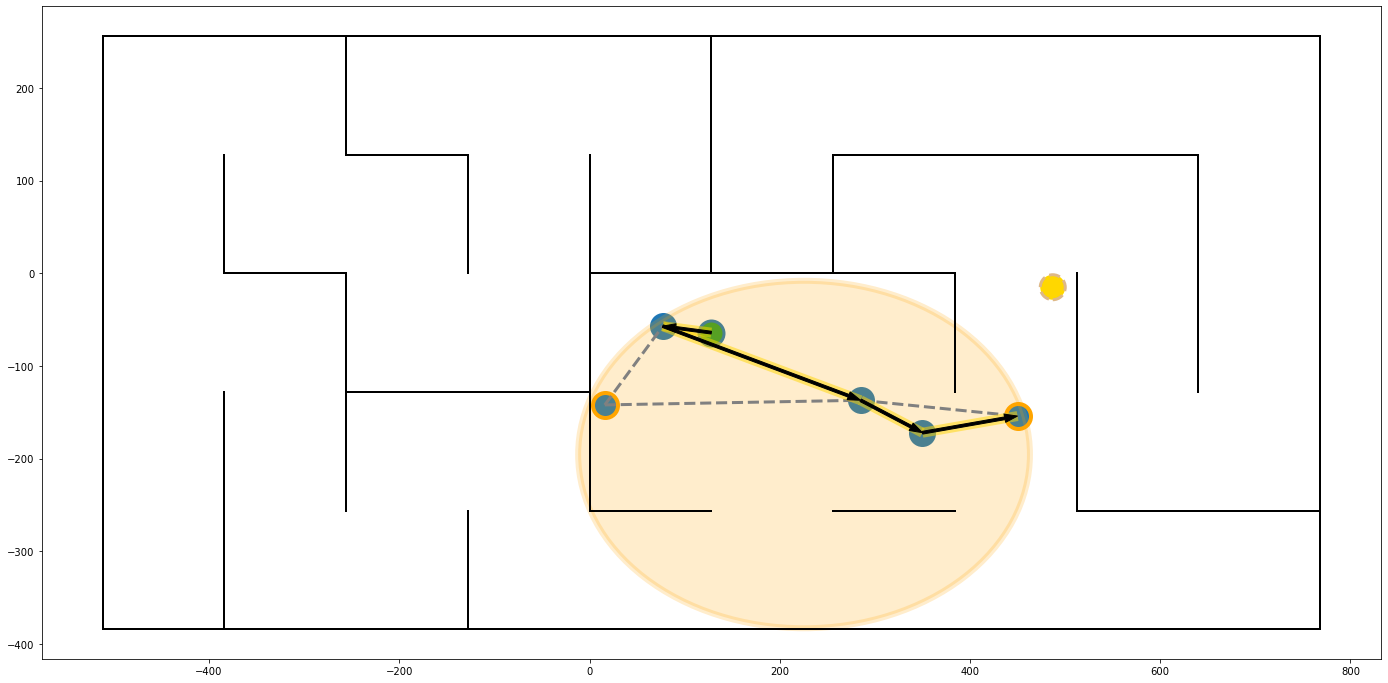

In [521]:
fig = plt.figure(figsize=(24, 12))

env.plot_topdown(False)

ax = plt.gca()

starts = positions[exploration_edges[:, 0], :2]
ends = positions[exploration_edges[:, 1], :2]
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=3, color='gray', linestyle='--')
ax.add_collection(lc)

full_path = [good_start[:2], *positions[exploration_path, :2]] # , good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

for line in lines:
    x, y = line[0]
    dx = line[1][0] - x
    dy = line[1][1] - y
    plt.arrow(x, y, dx, dy, width=3, length_includes_head=True, color='black', zorder=10)
    
lc = mc.LineCollection(lines,
                       linewidths=10, color='gold', alpha=0.5)
ax.add_collection(lc)
    
frontier_landmarks = [35, 79]
    
exploration_landmarks = np.setdiff1d(np.unique(exploration_edges), frontier_landmarks).tolist()

plt.scatter(positions[exploration_landmarks, 0], positions[exploration_landmarks, 1], s=625, linewidths=2,
            color='tab:blue', edgecolor='tab:blue', label='Landmarks')
plt.scatter(positions[frontier_landmarks, 0], positions[frontier_landmarks, 1], s=625, linewidths=4,
            color='tab:blue', edgecolor='orange', label='Frontier landmarks')
plt.scatter(*good_start[:2], marker='o', s=625, color='tab:green', linewidths=3, edgecolor='tab:blue', label='Start')
plt.scatter(*positions[good_path[4], :2], marker='o', s=625, color='gold', linewidths=3, edgecolor='burlywood',
            label='New Landmark', linestyle='--')
explored = []
explored.append(matplotlib.patches.Ellipse((225, -195), 475, 375))
pc = mc.PatchCollection(explored, facecolor='orange', alpha=0.2, edgecolor='orange', linewidth=6)
ax.add_collection(pc)

In [524]:
def plot_invis(env, fig):
    env.reset()
    state = env.state

    for s in state.sectors:
        # Plot sector on map
        for l in s.lines:
            if l.is_blocking:
                fig.plot([l.x1, l.x2], [l.y1, l.y2], color='black', alpha=0)

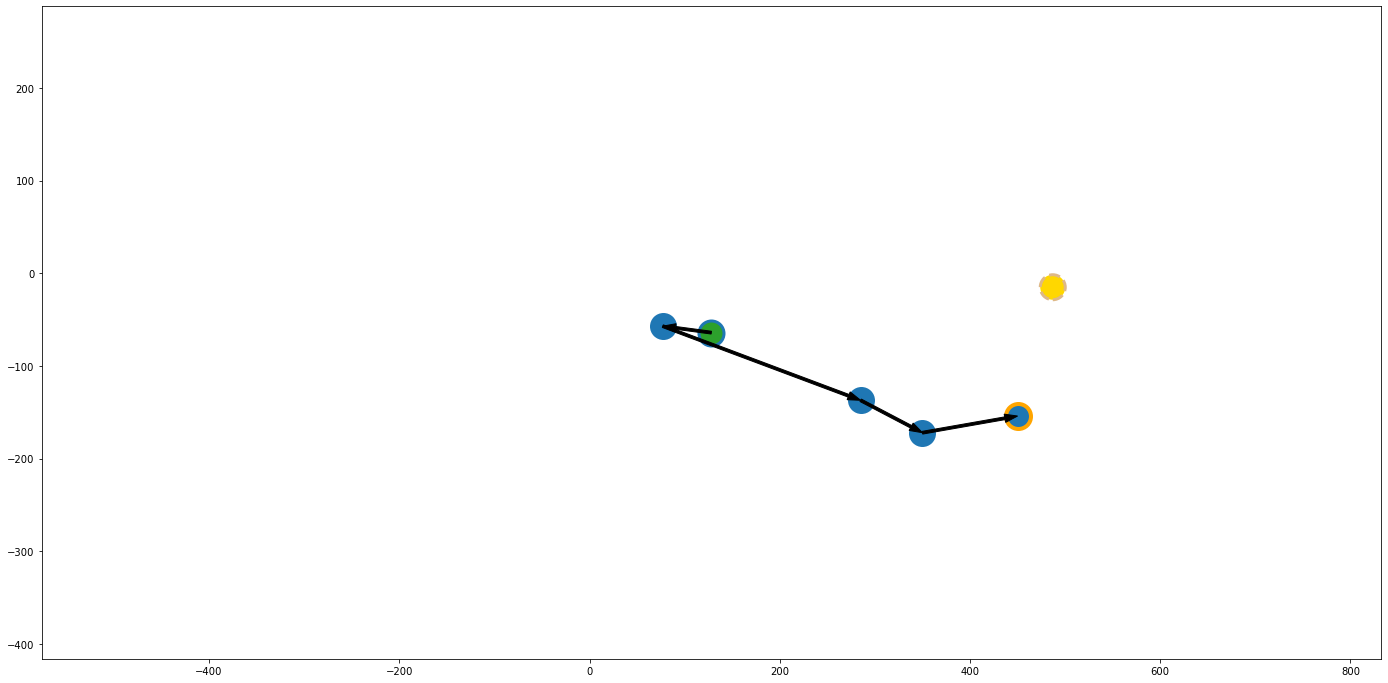

In [527]:
fig = plt.figure(figsize=(24, 12))
ax = plt.gca()
plot_invis(env, ax)

full_path = [good_start[:2], *positions[exploration_path, :2]] # , good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

for line in lines:
    x, y = line[0]
    dx = line[1][0] - x
    dy = line[1][1] - y
    plt.arrow(x, y, dx, dy, width=3, length_includes_head=True, color='black', zorder=10)

plt.scatter(positions[exploration_path[:-1], 0], positions[exploration_path[:-1], 1], s=625, linewidths=2,
            color='tab:blue', edgecolor='tab:blue', label='Landmarks')
plt.scatter(positions[exploration_path[-1:], 0], positions[exploration_path[-1:], 1], s=625, linewidths=4,
            color='tab:blue', edgecolor='orange', label='Frontier landmarks')
plt.scatter(*good_start[:2], marker='o', s=625, color='tab:green', linewidths=3, edgecolor='tab:blue', label='Start')
plt.scatter(*positions[good_path[4], :2], marker='o', s=625, color='gold', linewidths=3, edgecolor='burlywood',
            label='New Landmark', linestyle='--')

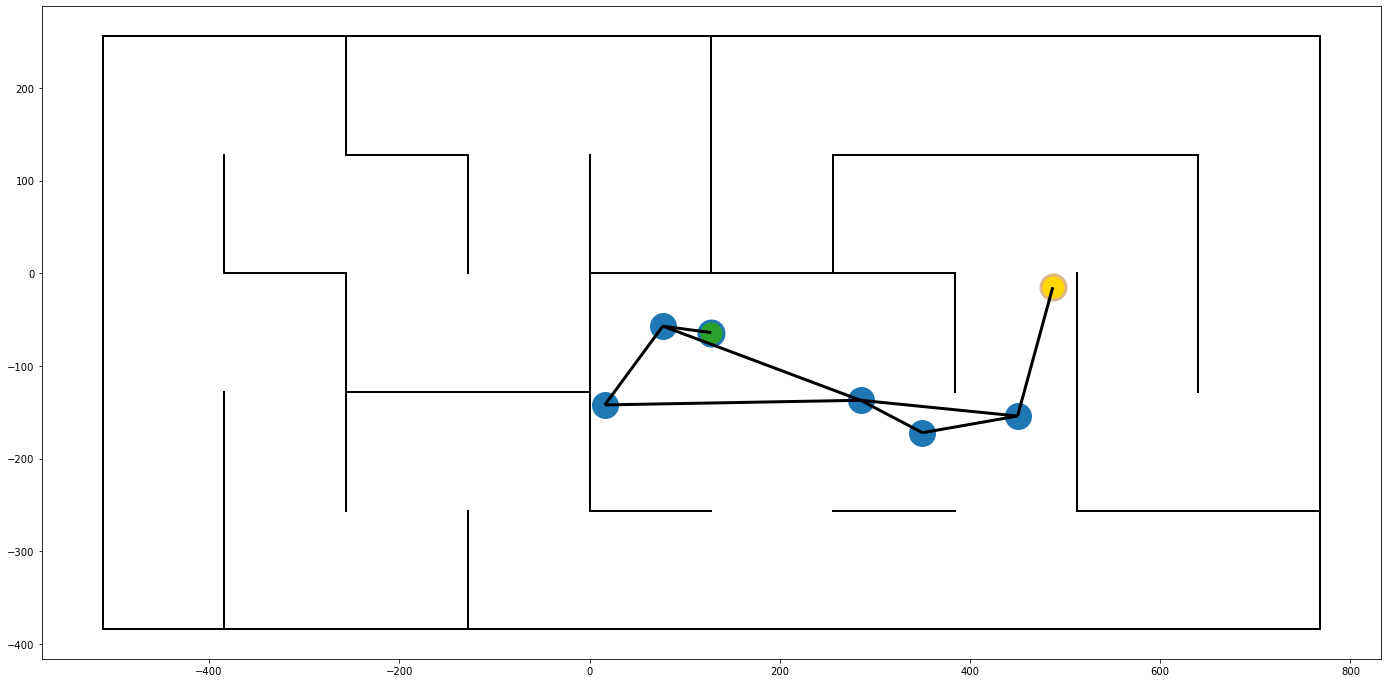

In [526]:
fig = plt.figure(figsize=(24, 12))

env.plot_topdown(False)

ax = plt.gca()

starts = np.vstack([good_start[:2], positions[exploration_edges[:, 0], :2],
                    positions[exploration_path[-1], :2]])
ends = np.vstack([positions[exploration_path[0], :2], positions[exploration_edges[:, 1], :2],
                  positions[good_path[4], :2]])
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=3, color='black')
ax.add_collection(lc)

exploration_landmarks = np.unique(exploration_edges).tolist()

plt.scatter(positions[exploration_landmarks, 0], positions[exploration_landmarks, 1], s=625, linewidths=2,
            edgecolor='tab:blue', label='Landmarks')
plt.scatter(*good_start[:2], marker='o', s=625, color='tab:green', linewidths=3, edgecolor='tab:blue', label='Start')
plt.scatter(*positions[good_path[4], :2], marker='o', s=625, color='gold', linewidths=3, edgecolor='burlywood',
            label='New Landmark')

In [249]:
full_landmarks = np.unique(exploration_landmarks + good_path).tolist()
cross_full_landmarks = np.array(list(it.product(full_landmarks, full_landmarks)))
full_path_edges = np.zeros((N, N), dtype=bool)
full_path_edges[cross_full_landmarks[:, 0], cross_full_landmarks[:, 1]] = 1
full_path_edges = edge_weights.copy() * full_path_edges
full_path_edges = np.argwhere(full_path_edges > 0)

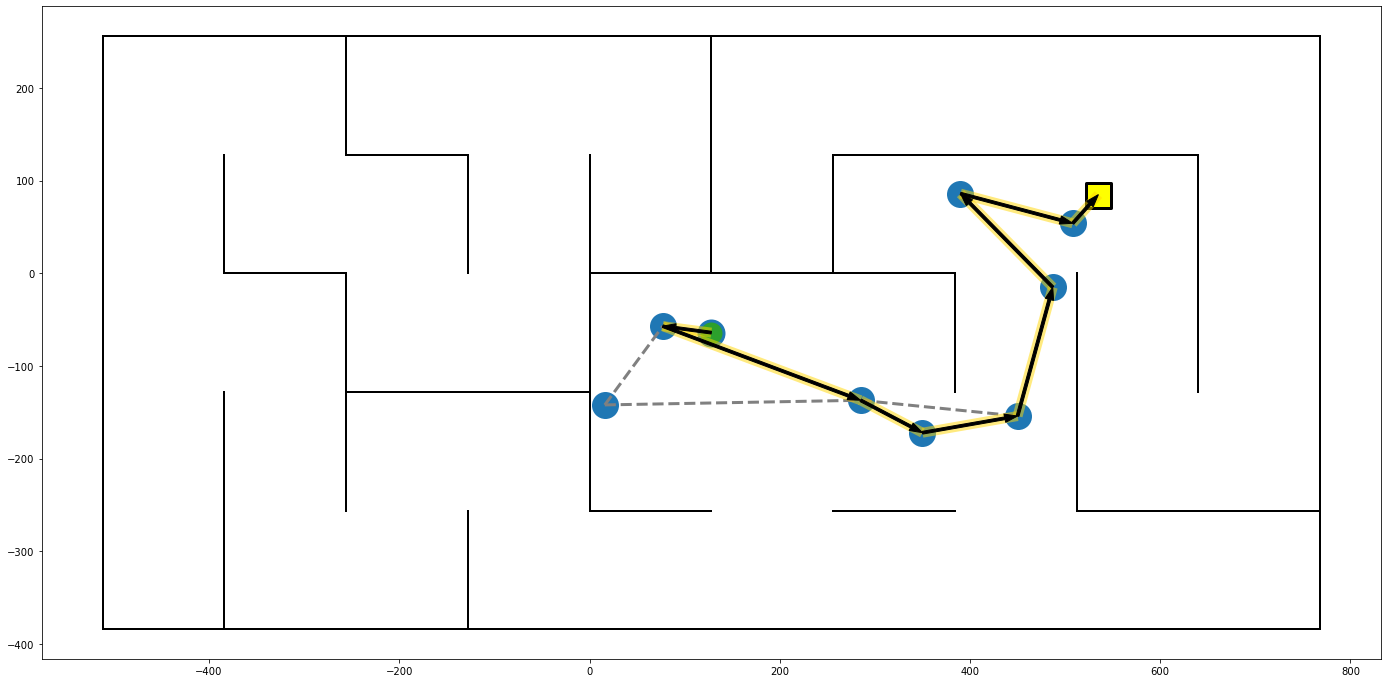

In [528]:
fig = plt.figure(figsize=(24, 12))

env.plot_topdown(False)

ax = plt.gca()

starts = positions[full_path_edges[:, 0], :2]
ends = positions[full_path_edges[:, 1], :2]
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=3, color='gray', linestyle='--')
ax.add_collection(lc)

full_path = [good_start[:2], *positions[good_path, :2], good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

for line in lines:
    x, y = line[0]
    dx = line[1][0] - x
    dy = line[1][1] - y
    plt.arrow(x, y, dx, dy, width=3, length_includes_head=True, color='black', zorder=10)

lc = mc.LineCollection(lines,
                       linewidths=10, color='gold', alpha=0.5)
ax.add_collection(lc)
    
full_landmarks = np.unique(full_path_edges).tolist()

plt.scatter(positions[full_landmarks, 0], positions[full_landmarks, 1], s=625, linewidths=2,
            color='tab:blue', edgecolor='tab:blue', label='Landmarks')
plt.scatter(*good_start[:2], marker='o', s=625, color='tab:green', linewidths=3, edgecolor='tab:blue', label='Start')
plt.scatter(*good_goal[:2], marker='s', s=625, color='yellow', linewidths=3, edgecolor='black', label='Goal')

# SFS ViZDoom Heatmaps

1. sample points uniformly across map
2. for each point, move around until buffer is full
3. then compute SFS relative to start position

In [48]:
def get_full_state(env, position, repeat=False):
    if repeat:
        return env.get_obs_at(position, idx=-1)
    env.get_obs_at(position)
    for _ in range(3):
        state, _, _, info = env.step(env.action_space.sample())
    return (state, info.position)

In [531]:
env = VizDoomEnv(**config['env'])

In [49]:
env.reset()
start_state, start_pos = get_full_state(env, env.start_info[1], True)
start_sf = get_s_features(start_state, feature_model, dsr_model)

In [50]:
size_per_box = 20
num_samples_per_box = 5

In [51]:
x_starts = range(int(env.min_x), int(env.max_x), size_per_box)
y_starts = range(int(env.min_y), int(env.max_y), size_per_box)

In [52]:
print(len(list(it.product(x_starts, y_starts))))

2048


In [53]:
sfs_data = defaultdict(list)

In [54]:
i = 0
for x_start, y_start in it.product(x_starts, y_starts):
    for _ in range(num_samples_per_box):
        sample_x = np.random.uniform(x_start, x_start + size_per_box)
        sample_y = np.random.uniform(y_start, y_start + size_per_box)
        sample_theta = np.random.uniform(0, 360)
        sample_position = [sample_x, sample_y, sample_theta]
        sample_state, sample_pos = get_full_state(env, sample_position, True)
        sample_sf = get_s_features(sample_state, feature_model, dsr_model)
        sfs_data[(x_start, y_start)].append(np.dot(start_sf, sample_sf))
    i += 1
    if i > 100:
        print('RESET')
        env.reset()
        i = 0

RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET
RESET


In [55]:
plot_sfs_data = np.array(list(sfs_data.keys())).astype('float')
plot_sfs_data = np.insert(plot_sfs_data, 2, list(map(np.mean, list(sfs_data.values()))), axis=1)

In [57]:
import matplotlib

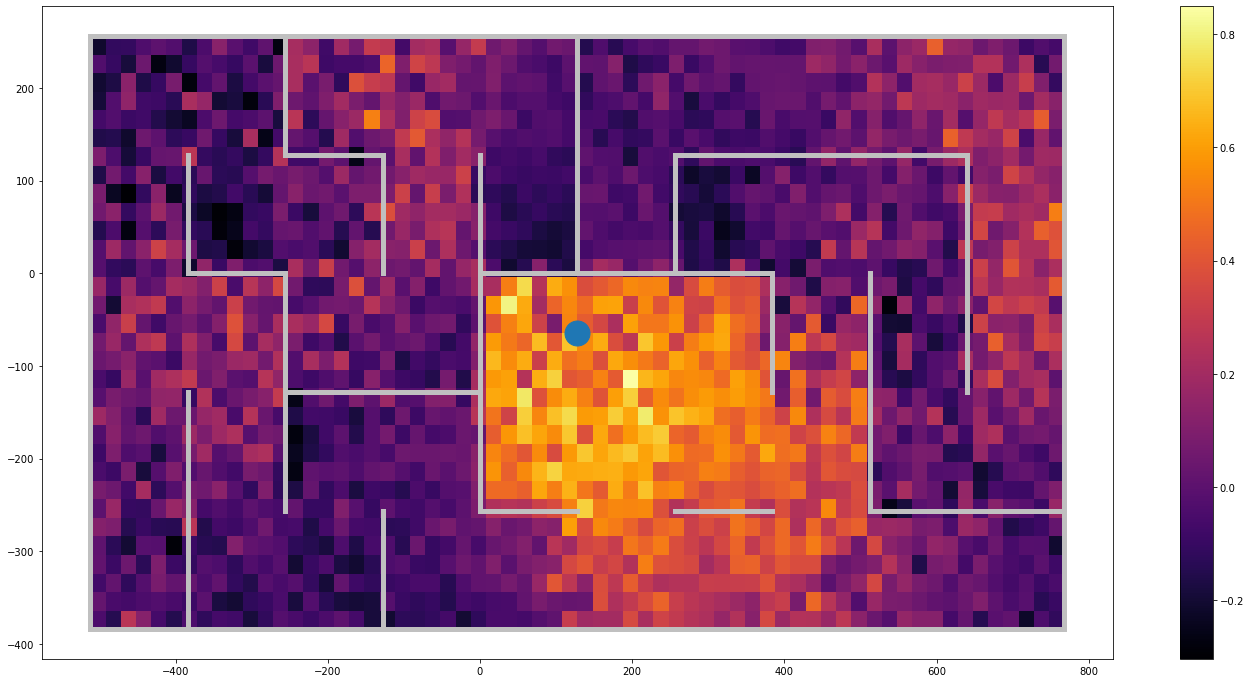

In [58]:
plt.figure(figsize=(24, 12))
env.reset()
state = env.state

for s in state.sectors:
    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            plt.plot([l.x1, l.x2], [l.y1, l.y2], color='silver', linewidth=5)

plt.scatter(*start_pos[:2], s=625, marker='o', zorder=10, color='tab:blue')

rects = []
for x, y in plot_sfs_data[:, :2]:
    rect = matplotlib.patches.Rectangle((x, y), size_per_box, size_per_box)
    rects.append(rect)
rects = mc.PatchCollection(rects, cmap=cm.inferno)
rects.set_array(plot_sfs_data[:, 2])
ax = plt.gca()
ax.add_collection(rects)
plt.colorbar(rects)

In [3]:
with open('../experiments/configs/small-eval-settings.json') as f:
    small_goals = json.load(f)

In [4]:
with open('../experiments/configs/memory-small-full.json') as f:
    small_config = json.load(f)
small_config['env']['config'] = '../' + small_config['env']['config']

In [5]:
with open('../experiments/configs/memory-train-full.json') as f:
    train_config = json.load(f)
train_config['env']['config'] = '../' + train_config['env']['config']

In [102]:
small_env = VizDoomEnv(**small_config['env'])
train_env = VizDoomEnv(**train_config['env'])

In [103]:
levels = ['easy', 'medium', 'hard', 'hardest']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

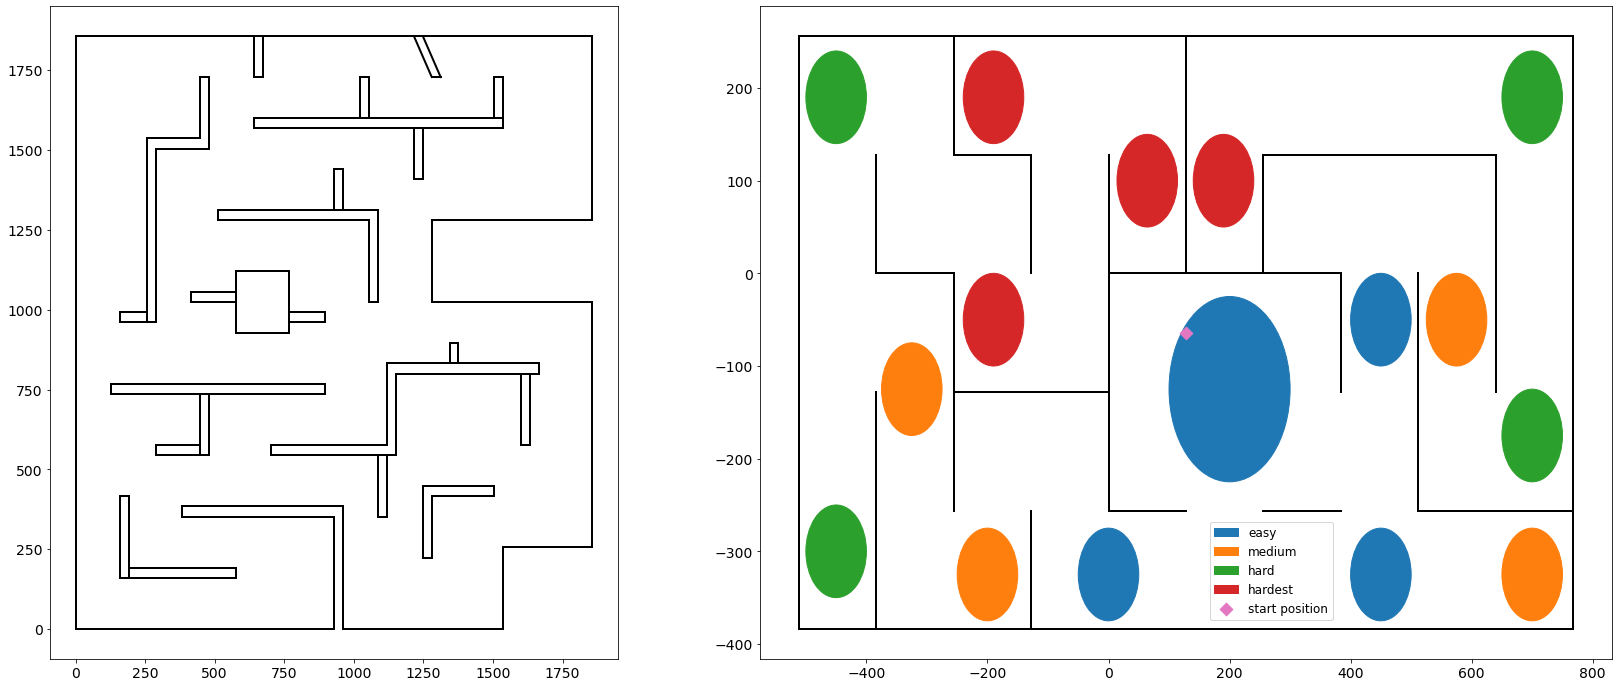

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12), gridspec_kw={'width_ratios': [1, 1.5]})
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

plot_topdown(train_env, ax1)
plot_topdown(small_env, ax2)
circles = []
for level, color in zip(levels, colors):
    goal_areas = small_goals[level]
    for goal_area in goal_areas:
        x, y, r = goal_area
        circle = plt.Circle((x, y), r, color=color, label=level, zorder=-1)
        ax2.add_artist(circle)
    circles.append(circle)
agent = ax2.scatter(*small_config['env']['start_position'][:2], s=81, color='tab:pink', marker='D', label='start position', zorder=1)
ax2.legend(handles=[*circles, agent], loc='lower center', bbox_to_anchor=(0.60, 0.05), fontsize=12)
plt.savefig('images/mazes.png', bbox_inches='tight')

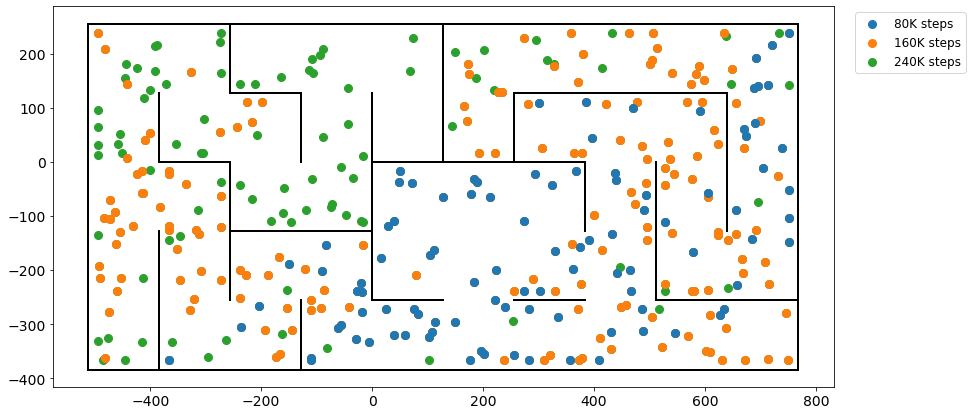

In [547]:
plt.figure(figsize=(14, 7))

landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_9999.npz')
positions = landmarks['positions']
plot_topdown(small_env, plt)
plt.scatter(positions[:, 0], positions[:, 1], label='80K steps', s=64, zorder=3)

landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_19999.npz')
positions = landmarks['positions']
plt.scatter(positions[:, 0], positions[:, 1], label='160K steps', s=64, zorder=2)

landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_29999.npz')
positions = landmarks['positions']
plt.scatter(positions[:, 0], positions[:, 1], label='240K steps', s=64, zorder=1)

plt.tick_params(labelsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.02, 1))
plt.savefig('images/landmark_expansion.png', bbox_inches='tight')

In [198]:
small_config['agent']['feature_model_kwargs']['fixed_weights_path'] = '../' + \
    small_config['agent']['feature_model_kwargs']['fixed_weights_path'] 

In [449]:
feature_model = FixedVizDoomModel(**small_config['agent']['feature_model_kwargs'])
feature_model.to(device)

FixedVizDoomModel(
  (encoder): Linear(in_features=1, out_features=1, bias=True)
)

In [548]:
weights = torch.load('../data/local/20200922/vizdoom/run_0/itr_249999.pkl', map_location=device)
landmarks = np.load('../data/local/20200922/vizdoom/run_0/landmarks_itr_249999.npz')

In [549]:
dsr_model = DsrModel(train_env.observation_space.shape,
                     train_env.action_space.n, **train_config['agent']['model_kwargs']).to(device)

In [550]:
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()
dsr_model.to(device)

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=14336, bias=True)
    )
  )
  (q_estimate): Linear(in_features=2048, out_features=1, bias=True)
)

In [551]:
def get_s_features(state, norm=True, numpy=True):
    features = feature_model(torch.Tensor(state).unsqueeze(0).to(device))
    s_features = dsr_model(features, mode='dsr')
    if norm:
        s_features = torch.mean(s_features, dim=1)
        s_features = s_features / torch.norm(s_features, p=2, dim=1, keepdim=True)
    if numpy:
        s_features = s_features.detach().cpu().numpy().squeeze()
    return s_features

In [552]:
positions = landmarks['positions']
N = len(positions)

dsr = landmarks['dsr']
norm_dsr = dsr / np.linalg.norm(dsr, ord=2, axis=1, keepdims=True)
dsr_sim = np.matmul(norm_dsr, norm_dsr.T)
dsr_sim[np.eye(N, dtype=bool)] = -1
features = landmarks['features']
norm_features = features / np.linalg.norm(features, ord=2, axis=1, keepdims=True)
feature_sim = np.matmul(norm_features, norm_features.T)

edge_random_steps = landmarks['edge_random_steps']
edge_random_transitions = landmarks['edge_random_transitions']
edge_subgoal_steps = landmarks['edge_subgoal_steps']
edge_subgoal_failures = landmarks['edge_subgoal_failures']
edge_subgoal_transitions = landmarks['edge_subgoal_transitions']

random_steps = edge_random_steps + np.tril(edge_random_steps, -1).T
random_transitions = edge_random_transitions + np.tril(edge_random_transitions, -1).T

subgoal_steps = edge_subgoal_steps + np.tril(edge_subgoal_steps, -1).T
subgoal_failures = edge_subgoal_failures + np.tril(edge_subgoal_failures, -1).T
subgoal_transitions = edge_subgoal_transitions + np.tril(edge_subgoal_transitions, -1).T

average_random_steps = random_steps / np.clip(random_transitions, 1, None)
average_subgoal_steps = subgoal_steps / np.clip(subgoal_transitions, 1, None)

transitions = random_transitions + subgoal_transitions

In [554]:
print('Number of landmarks:', N)
print('Number of non-zero random transitions:', np.argwhere(random_transitions > 0).shape[0])
percentile = 50
threshold = np.percentile(random_transitions[random_transitions > 0], percentile)
print('{} percentile of random transitions:'.format(percentile), 
      threshold)

temporally_nearby_threshold = max(N // 10, 10)
temporally_nearby_landmarks = np.tril(np.triu(np.ones((N), dtype=bool), 1), temporally_nearby_threshold)

subgoal_edges = np.argwhere(subgoal_transitions > 0)
print('Number of subgoal edges:', subgoal_edges.shape[0])
failure_edges = np.argwhere(subgoal_failures > 0)
print('Number of failure edges:', failure_edges.shape[0])

true_edges = random_transitions >= threshold
# true_edges = temporally_nearby_landmarks & true_edges

k = 5
nearest_neighbors = np.argpartition(true_edges * random_transitions, -k)[:, -k:]
k_filter = np.zeros((N, N), dtype=bool)
idx = np.vstack([np.arange(N)] * k).T
k_filter[idx, nearest_neighbors] = True
true_edges = k_filter & true_edges

# true_edges = (subgoal_failures <= 1) & true_edges

edge_weights = true_edges * (np.exp(-1 * random_transitions))
edge_weights[(edge_weights > 0) & (subgoal_failures > 1)] = \
    edge_weights[(edge_weights > 0) & (subgoal_failures >1)] + 5000

edges = np.argwhere(edge_weights > 0)
print('Number of edges:', edges.shape[0])

Number of landmarks: 2433
Number of non-zero random transitions: 41219
50 percentile of random transitions: 1.0
Number of subgoal edges: 8456
Number of failure edges: 2552
Number of edges: 10121


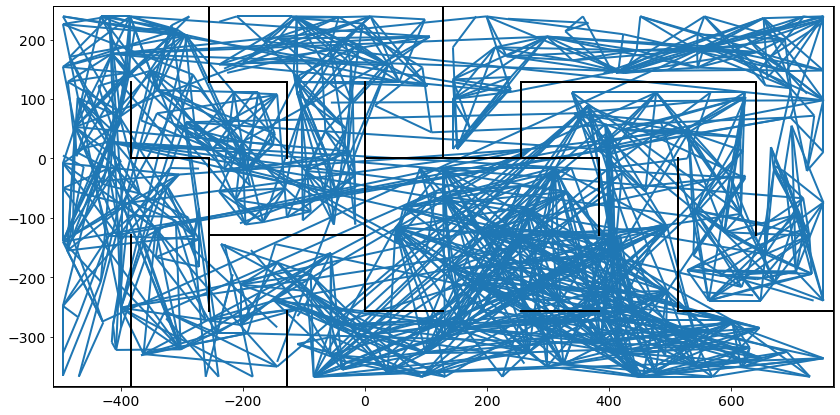

In [542]:
starts = positions[edges[:, 0], :2]
ends = positions[edges[:, 1], :2]
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=2)
fig, ax = plt.subplots(figsize=(14, 7))
plt.tick_params(labelsize=14)
ax.set_xlim(small_env.min_x, small_env.max_x)
ax.set_ylim(small_env.min_y, small_env.max_y)
plot_topdown(small_env, ax)
ax.add_collection(lc)
plt.savefig('images/edges-failures-temporal-landmarks.png')

In [556]:
with open('../experiments/configs/2589-small-fixed-start-goal-pairs.json') as f:
    goal_pairs = json.load(f)

with open('../experiments/configs/225-train-random-start-goal-pairs.json') as f:
    goal_pairs = json.load(f)

In [557]:
env = train_env

In [611]:
def get_path(goal_idx):
    start_pos, goal_pos = goal_pairs['easy'][goal_idx]
    start_state, start_pos = env.get_obs_at(start_pos, idx=3)
    goal_state, goal_pos = env.get_obs_at(goal_pos, idx=-1)
    start_sf = get_s_features(start_state)
    goal_sf = get_s_features(goal_state)

    start_sim = np.matmul(norm_dsr, start_sf).max()
    start_landmark = np.matmul(norm_dsr, start_sf).argmax()

    goal_sim = np.matmul(norm_dsr, goal_sf.T).max()
    goal_landmark = np.matmul(norm_dsr, goal_sf.T).argmax()

    print('SF start:', start_landmark)
    print('SF goal:', goal_landmark)
    
    graph = nx.from_numpy_array(edge_weights)
    has_path = nx.has_path(graph, start_landmark, goal_landmark)
    if has_path:
        path = nx.shortest_path(graph, start_landmark, goal_landmark, weight='weight')
        print('Found path:', path)
    else:
        print('No path from {} to {}'.format(start_landmark, goal_landmark))
    
    return start_pos, goal_pos, path

In [617]:
good_start, good_goal, good_path = get_path(11)
bad_start, bad_goal, bad_path = get_path(5)

SF start: 422
SF goal: 1400
Found path: [422, 380, 397, 466, 385, 368, 375, 389, 394, 1400]
SF start: 111
SF goal: 921
Found path: [111, 124, 31, 39, 1287, 717, 1375, 715, 598, 596, 778, 688, 675, 776, 503, 500, 643, 637, 491, 594, 375, 1352, 365, 377, 5, 216, 103, 1978, 970, 971, 6, 299, 963, 914, 339, 918, 921]


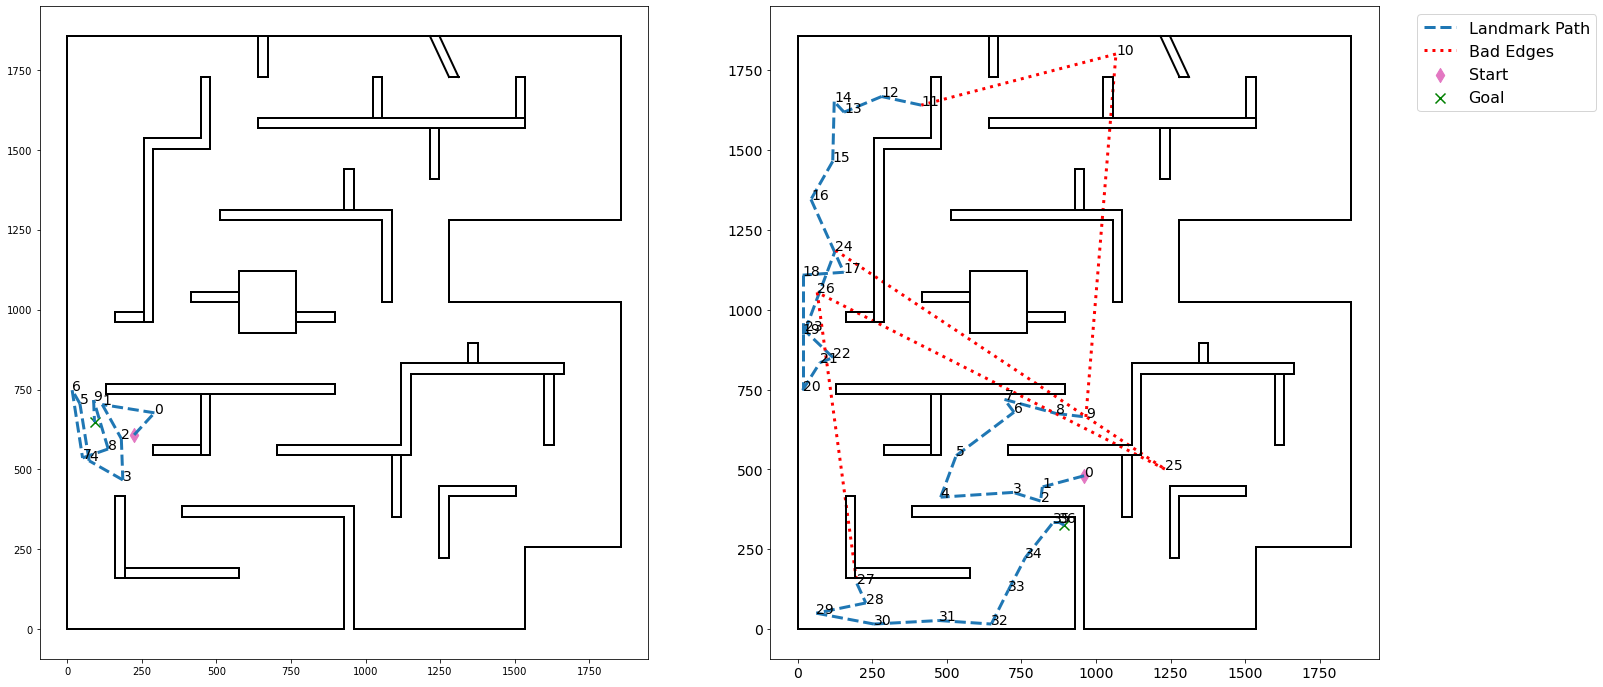

In [625]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
plot_topdown(env, ax1)
for i, landmark in enumerate(good_path):
     ax1.text(*positions[landmark, :2], str(i), fontsize=14)

lines = []
full_path = [good_start[:2], *positions[good_path, :2], good_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))


lc = mc.LineCollection(lines, linewidths=3, linestyle='--', label='Landmark Path')
ax1.add_collection(lc)

ax1.scatter(*good_start[:2], marker='d', s=100, color='tab:pink', label='Start')
ax1.scatter(*good_goal[:2], marker='x', s=100, color='green', label='Goal')

plot_topdown(env, ax2)
for i, landmark in enumerate(bad_path):
     ax2.text(*positions[landmark, :2], str(i), fontsize=14)

lines = []
full_path = [bad_start[:2], *positions[bad_path, :2], bad_goal[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

bad_lines = [10, 11, 25, 26, 27]
lc = mc.LineCollection([lines[i] for i in range(len(lines)) if i not in bad_lines], 
                       linewidths=3, linestyle='--', label='Landmark Path')
ax2.add_collection(lc)
lc = mc.LineCollection([lines[i] for i in bad_lines], 
                       linewidths=3, linestyle=':', color='red', label='Bad Edges')
ax2.add_collection(lc)

ax2.scatter(*bad_start[:2], marker='d', s=100, color='tab:pink', label='Start')
ax2.scatter(*bad_goal[:2], marker='x', s=100, color='green', label='Goal')

plt.tick_params(labelsize=14)
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1))
plt.savefig('images/random-paths.png', bbox_inches='tight')